In [24]:
# Import libraries that will be needed for the lab

import xgboost as xgb
import numpy as np
from collections import OrderedDict
import gc
from glob import glob
import os
import pandas as pd
from copy import copy
from time import time
from sklearn.metrics import roc_auc_score,confusion_matrix,accuracy_score,classification_report,roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from timeit import default_timer
import matplotlib.pyplot as plt
import pickle

# Set the seed for numpy
np.random.seed(123)

# Display all columns of Pandas' dataframes by default
pd.set_option('display.max_columns', None)

data_path = '../../../kddcup.data.corrected'

In [5]:
col_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins","logged_in",
             "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files","num_outbound_cmds",
             "is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
             "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
             "dst_host_same_src_port_rate","dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
             "dst_host_srv_rerror_rate","label"]

df = pd.read_csv(data_path, names=col_names, index_col=False,header=None)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [6]:
df.shape

(4898431, 42)

In [7]:
types_dict = dict(df.dtypes)
column_names = list(types_dict.keys())
types = list(types_dict.values())

In [8]:
values = list(df.iloc[0])
len(types),len(values)

(42, 42)

In [9]:
def check_dtypes_df(df):
    types_dict = dict(df.dtypes)
    column_names = list(types_dict.keys())
    types = list(types_dict.values())
    dtype_val_df = pd.DataFrame()
    dtype_val_df["column_names"]=column_names
    dtype_val_df["values"]=list(df.iloc[0])
    dtype_val_df["types"]=types
    print(dtype_val_df)


In [10]:
check_dtypes_df(df)

                   column_names   values    types
0                      duration        0    int64
1                 protocol_type      tcp   object
2                       service     http   object
3                          flag       SF   object
4                     src_bytes      215    int64
5                     dst_bytes    45076    int64
6                          land        0    int64
7                wrong_fragment        0    int64
8                        urgent        0    int64
9                           hot        0    int64
10            num_failed_logins        0    int64
11                    logged_in        1    int64
12              num_compromised        0    int64
13                   root_shell        0    int64
14                 su_attempted        0    int64
15                     num_root        0    int64
16           num_file_creations        0    int64
17                   num_shells        0    int64
18             num_access_files        0    int64


In [11]:
df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4898431.0,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06,4.898431e+06
mean,4.834243e+01,1.834621e+03,1.093623e+03,5.716116e-06,6.487792e-04,7.961733e-06,1.243766e-02,3.205108e-05,1.435290e-01,8.088304e-03,6.818510e-05,3.674646e-05,1.293496e-02,1.188748e-03,7.430951e-05,1.021143e-03,0.0,4.082940e-07,8.351654e-04,3.349734e+02,2.952671e+02,1.779703e-01,1.780370e-01,5.766509e-02,5.773010e-02,7.898842e-01,2.117961e-02,2.826080e-02,2.329811e+02,1.892142e+02,7.537132e-01,3.071111e-02,6.050520e-01,6.464107e-03,1.780911e-01,1.778859e-01,5.792780e-02,5.765941e-02
std,7.233298e+02,9.414311e+05,6.450123e+05,2.390833e-03,4.285434e-02,7.215084e-03,4.689782e-01,7.299408e-03,3.506116e-01,3.856481e+00,8.257146e-03,8.082432e-03,3.938075e+00,1.241857e-01,8.737590e-03,3.551048e-02,0.0,6.389788e-04,2.888716e-02,2.119908e+02,2.459927e+02,3.818756e-01,3.822541e-01,2.322529e-01,2.326604e-01,3.892958e-01,8.271458e-02,1.405596e-01,6.402094e+01,1.059128e+02,4.111860e-01,1.085432e-01,4.809877e-01,4.125978e-02,3.818382e-01,3.821774e-01,2.309428e-01,2.309777e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,4.500000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1.210000e+02,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,4.900000e+01,4.100000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,5.200000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.100000e+02,5.100000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,1.032000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,5.110000e+02,5.110000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.550000e+02,2.550000e+02,1.000000e+00,4.000000e-02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.

In [12]:
list(df["label"].unique())

['normal.',
 'buffer_overflow.',
 'loadmodule.',
 'perl.',
 'neptune.',
 'smurf.',
 'guess_passwd.',
 'pod.',
 'teardrop.',
 'portsweep.',
 'ipsweep.',
 'land.',
 'ftp_write.',
 'back.',
 'imap.',
 'satan.',
 'phf.',
 'nmap.',
 'multihop.',
 'warezmaster.',
 'warezclient.',
 'spy.',
 'rootkit.']

In [13]:
x = df.drop(columns=["label"],axis=1)
x = pd.get_dummies(x,dtype="int")
labels=[]
for i in df.label:
    if i == "normal.":
        labels.append(0)
    else:
        labels.append(1)
y = pd.DataFrame()
y["labels"]=labels
x.shape,y.shape

((4898431, 122), (4898431, 1))

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    test_size=.15, 
                                                    random_state=42)

In [15]:
len(x_train),len(x_test)

(4163666, 734765)

In [ ]:
preprocessed_data = {
    'x_train':x_train,
    'y_train':y_train,
    'x_test':x_test,
    'y_test':y_test,
}

# pickle the preprocessed_data
path = 'preprocessed_data_full.pkl'
out = open(path, 'wb')
pickle.dump(preprocessed_data, out)
out.close()

In [16]:
%%time 

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
evals = [(dtest, 'test',), (dtrain, 'train')]

CPU times: user 18.9 s, sys: 1.89 s, total: 20.8 s
Wall time: 4.38 s


In [17]:
params = {
    'num_rounds':        10,
    'max_depth':         8,
    'max_leaves':        2**8,
    'alpha':             0.9,
    'eta':               0.1,
    'gamma':             0.1,
    'learning_rate':     0.1,
    'subsample':         1,
    'reg_lambda':        1,
    'scale_pos_weight':  2,
    'tree_method':       'gpu_hist',
    'n_gpus':            1,
    'objective':         'binary:logistic',
    'verbose':           True
}

In [19]:
num_rounds = params["num_rounds"]
model = xgb.train(params, dtrain, num_rounds, evals=evals)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [07:10:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [07:10:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "n_gpus", "num_rounds", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	test-logloss:0.39567	train-logloss:0.39561
[1]	test-logloss:0.33156	train-logloss:0.33150
[2]	test-logloss:0.28437	train-logloss:0.28432
[3]	test-logloss:0.24709	train-logloss:0.24705
[4]	test-logloss:0.21657	train-logloss:0.21653
[5]	test-logloss:0.19101	train-logloss:0.19098
[6]	test-logloss:0.16929	train-logloss:0.16926
[7]	test-logloss:0.15051	train-logloss:0.15048
[8]	test-logloss:0.13418	train-logloss:0.13415
[9]	test-logloss:0.11986	train-logloss:0.11983


In [20]:
# make predictions on the test set using our trained model
preds = model.predict(dtest)
print(preds)

[0.2841285 0.9364746 0.2841285 ... 0.9364746 0.9364746 0.9364746]


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [07:11:29] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


In [22]:
threshold = .5
pred_labels = (preds > threshold).astype(int)
print(pred_labels)

[0 1 0 ... 1 1 1]


In [25]:
# compute the auc
auc = roc_auc_score(y_test, preds)
print(auc)

0.9999708269760866


In [27]:
print ('Accuracy:', accuracy_score(y_test, pred_labels))

Accuracy: 0.999503242533327


Confusion Matrix :


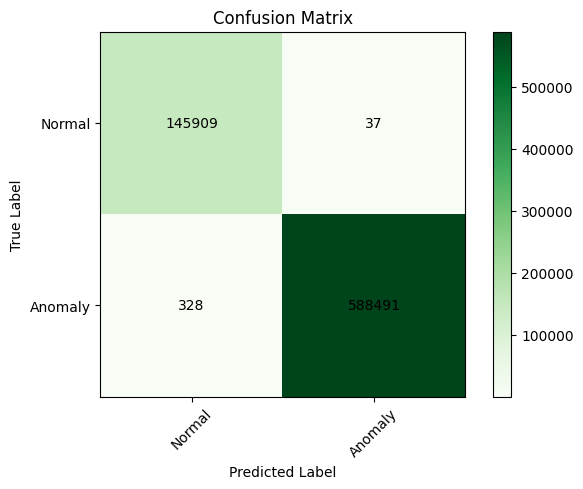

In [28]:
results = confusion_matrix(y_test, pred_labels) 

print ('Confusion Matrix :')

def plot_confusion_matrix(cm, target_names, title='Confusion Matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in range(width):
        for y in range(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


plot_confusion_matrix(results, ['Normal','Anomaly'])

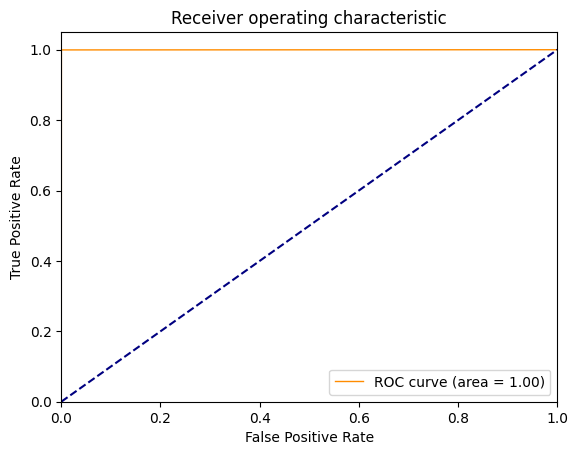

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, pred_labels)
roc_auc = roc_auc_score(y_test, pred_labels)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 10)